In [1]:
import numpy as np
from sympy import *
from scipy import optimize
from dataclasses import dataclass
import matplotlib.pyplot as plt

### Get intersection of line with circle
use $y = ax+b$ and $x^2+y^2 = r^2$

In [2]:
x = Symbol('x', real = True)
x0,y0,x1,y1 = symbols('x0 y0 x1 y1', real = True)
a,b,r = symbols('a b r', real = True)
dx,dy,dr,D = symbols('dx dy dr D', real = True)

In [3]:
sol = solve(x**2+(a*x+b)**2-r**2,x)

In [4]:
sol[0]

(-a*b + sqrt(a**2*r**2 - b**2 + r**2))/(a**2 + 1)

In [5]:
intersect1 = (-a*b-sqrt(r**2*(1+a**2)-b**2))/(1+a**2)
intersect2 = (-a*b+sqrt(r**2*(1+a**2)-b**2))/(1+a**2)
intersect1

(-a*b - sqrt(-b**2 + r**2*(a**2 + 1)))/(a**2 + 1)

In [6]:
intersect1_coordterms = intersect1.subs([(a,(y1-y0)/(x1-x0)), (b, y0-x0*(y1-y0)/(x1-x0))]).simplify()

In [7]:
intersect1_coordterms = intersect1_coordterms.subs([(x1-x0, dx), (y1-y0, dy), (dx**2+dy**2, dr**2), (x0*y1-x1*y0, D)]).simplify()
intersect1_coordterms

-(dx**2*sqrt((dr**2*r**2 - (dx*y0 - dy*x0)**2)/dx**2) + dy*(dx*y0 - dy*x0))/dr**2

In [8]:
((dx*y0-dy*x0)**2).subs([(dx,x1-x0), (dy, y1-y0)]).simplify()

(x0*y1 - x1*y0)**2

In [9]:
((dx*y0-dy*x0)**2).subs([(dx,x1-x0), (dy, y1-y0)]).simplify().subs([(x0*y1-x1*y0, D)])

D**2

In [10]:
intersect1_coordterms = intersect1_coordterms.subs([(dx*y0-dy*x0, D)])
intersect1_coordterms

-(D*dy + dx**2*sqrt((-D**2 + dr**2*r**2)/dx**2))/dr**2

In [11]:
intersect2_coordterms = intersect2.subs([(a,(y1-y0)/(x1-x0)), (b, y0-x0*(y1-y0)/(x1-x0))]).simplify()
intersect2_coordterms = intersect2_coordterms.subs([(x1-x0, dx), (y1-y0, dy), (dx**2+dy**2, dr**2), (x0*y1-x1*y0, D)]).simplify()
intersect2_coordterms = intersect2_coordterms.subs([(dx*y0-dy*x0, D)])
intersect2_coordterms

(-D*dy + dx**2*sqrt((-D**2 + dr**2*r**2)/dx**2))/dr**2

[Wolfram Mathworld](https://mathworld.wolfram.com/Circle-LineIntersection.html) gives the following equation:  
$x = \frac{Dd_y \pm sgn(d_y)d_x \sqrt{r^2d_r^2 - D^2}}{d_r^2}$

I'm missing $sgn(d_y)$ and my minus signs are incorrect.

In [12]:
@dataclass
class Ray:
    x0: float
    y0: float
    θ: float
        
    def line(self, dr):
        return [self.x0,self.y0],[self.x0+dr*np.cos(self.θ), self.y0+dr*np.sin(self.θ)]
    
@dataclass
class Line:
    x0: float
    y0: float
    x1: float
    y1: float

    def norm(self):
        dx = self.x1-self.x0
        dy = self.y1-self.y0
        dr = np.sqrt(dx**2+dy**2)
        return dx/dr, dy/dr
    
    def coeff(self):
        dx = self.x1-self.x0
        dy = self.y1-self.y0
        a = dy/dx
        b = self.y1-a*self.x1
        return  a,b
    
    def line(self, x):
        a,b = self.coeff()
        return a*x+b
    
@dataclass
class Circle:
    x: float
    y: float
    r: float
        
@dataclass
class LightTube:
    x0: float
    y0: float
    r: float

In [13]:
def circle_intersect(x0,y0,x1,y1,r):
    dx = x1-x0
    dy = y1-y0
    dr = np.sqrt(dx**2+dy**2)
    D = x0*y1 - x1*y0
    Δ = r**2*dr**2-D**2
    if Δ < 0:
        return np.nan
    elif Δ == 0:
        x = D*dy/dr**2
        y = -D*dx/dr**2
        return (x,y)
    else:
        x = [(D*dy + np.sign(dy)*dx*np.sqrt(Δ))/dr**2, (D*dy - np.sign(dy)*dx*np.sqrt(Δ))/dr**2]
        y = [(-D*dx + np.abs(dy)*np.sqrt(Δ))/dr**2, (-D*dx - np.abs(dy)*np.sqrt(Δ))/dr**2]
        return (x[0],y[0]), (x[1],y[1])

In [14]:
def circle_reflect(line,circle,length):
    cx = line.x1 - circle.x
    cy = line.y1 - circle.y
    tx = -cy
    ty = cx
    tx /= circle.r
    ty /= circle.r
    
    dx,dy = line.norm()
    dot = 2*(dx*tx+dy*ty)
    tx *= dot
    ty *= dot
    rx = tx - dx
    ry = ty - dy
    dr = np.sqrt(rx**2+ry**2)
    rx /= dr
    ry /= dr
    return Line(line.x1, line.y1, line.x1+rx*length, line.y1+ry*length)

In [15]:
ltest = Line(1/np.sqrt(2)-1,1/np.sqrt(2), 0-1, 0)
ctest = Circle(0,0,1)

In [16]:
refl = circle_reflect(ltest,ctest,1)

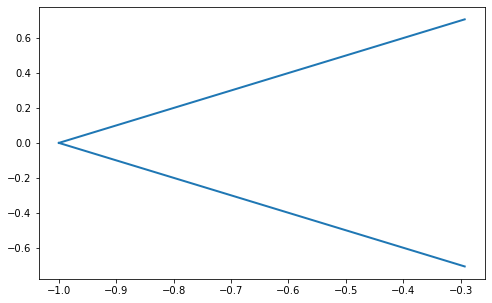

In [17]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot([ltest.x0, ltest.x1], [ltest.y0, ltest.y1], lw = 2, color = 'C0')
ax.plot([refl.x0, refl.x1], [refl.y0, refl.y1], lw = 2, color = 'C0')

In [18]:
def check_intersect(intersect, mirror):
    if np.any(np.isnan(intersect)):
        return np.nan, np.nan
    idm = np.argmin([intersect[0][0], intersect[1][0]])
    li = Line(X.x0, X.y0, intersect[idm][0], intersect[idm][1])
    # check if it actually hits the mirror
    if np.abs(li.y1) > 75/2:
        return li, np.nan
    else:
        refl = circle_reflect(li, mirror, 1)
        return li, refl

In [19]:
def check_hit_lighttube(ray,lighttube):
    a,b = ray.coeff()
    return np.abs(a*lighttube.x0 + b) < (lighttube.y0 + lighttube.r)

In [20]:
θ0 = np.pi - np.arcsin(37.5/112.5)
θ1 = np.pi + np.arcsin(37.5/112.5)

False


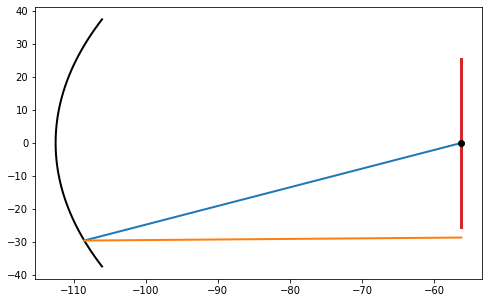

In [367]:
f = 56.25
lt = LightTube(-f,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -f
beam_y = 0
beam_dx = 0
beam_dy = 0

x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
angle = np.random.random()*np.pi + np.pi/2

X = Ray(x0,y0,angle)
x,y = zip(*X.line(100))

intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)
li, refl = check_intersect(intersect, mirror)


_θ = np.linspace(θ0, θ1, 101)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(2*f*np.cos(_θ), 2*f*np.sin(_θ), lw = 2, color = 'k')

if isinstance(li, Line):
    ax.plot([li.x0, li.x1], [li.y0, li.y1], lw = 2, color = 'C0')

if isinstance(refl, Line):
    ax.plot([refl.x0, lt.x0], refl.line(np.array([refl.x0, lt.x0])), lw = 2, color = 'C1')

ax.plot([lt.x0, lt.x0], [lt.y0-lt.r, lt.y0+lt.r], lw = 3, color = 'C3')

ax.plot(-f,0,'.k', ms = 12)

if isinstance(refl, Line):
    print(check_hit_lighttube(refl, lt))
else:
    print(False)

# Test all parallel lines to principal axis
should give 100% into pmt

In [368]:
from tqdm import tqdm

f = 56.25
lt = LightTube(0,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -f
beam_y = 0
beam_dx = 5
beam_dy = 20

N = int(1e5)
results = np.zeros([N,4])

for idn in tqdm(range(N)):
    x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
    y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
    angle = np.pi
    results[idn,:-1] = [x0,y0,angle]
    
    X = Ray(x0,y0,angle)
    x,y = zip(*X.line(200))
    intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

    li, refl = check_intersect(intersect, mirror)
    if isinstance(refl, Line):
        results[idn,3] = check_hit_lighttube(refl, lt)
    else:
        results[idn,3] = 0

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 17755.04it/s]


In [369]:
print(f'{100*results[:,-1].sum()/len(results):.2f}% of reflected left captured')

100.00% of reflected left captured


## Test random direction starting at focus
should give $\arcsin(25.4/f) = 0.2983$

In [370]:
f = 56.25
lt = LightTube(0,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -f
beam_y = 0
beam_dx = 0
beam_dy = 0

N = int(1e6)
results = np.zeros([N,4])

for idn in tqdm(range(N)):
    x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
    y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
    angle = np.random.random()*np.pi + np.pi/2
    results[idn,:-1] = [x0,y0,angle]
    
    X = Ray(x0,y0,angle)
    x,y = zip(*X.line(200))
    intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

    li, refl = check_intersect(intersect, mirror)
    if isinstance(refl, Line):
        results[idn,3] = check_hit_lighttube(refl, lt)
    else:
        results[idn,3] = 0

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:49<00:00, 20244.13it/s]


In [371]:
print(f'{100*results[:,-1].sum()/len(results):.2f}% of reflected left captured')

29.84% of reflected left captured


## Randomly spread out over an area

In [152]:
f = 56.25
lt = LightTube(0,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -f
beam_y = 0
beam_dx = 5
beam_dy = 20

N = int(1e6)
results = np.zeros([N,4])

for idn in tqdm(range(N)):
    x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
    y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
    angle = np.random.random()*np.pi + np.pi/2
    results[idn,:-1] = [x0,y0,angle]
    
    X = Ray(x0,y0,angle)
    x,y = zip(*X.line(200))
    intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

    li, refl = check_intersect(intersect, mirror)
    if isinstance(refl, Line):
        results[idn,3] = check_hit_lighttube(refl, lt)
    else:
        results[idn,3] = 0

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:51<00:00, 19414.43it/s]


In [153]:
print(f'{100*results[:,-1].sum()/len(results):.2f}% of reflected left captured')

28.68% of reflected left captured


Text(0, 0.5, 'y [mm]')

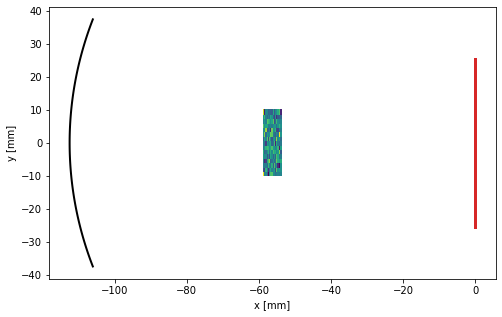

In [155]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist2d(results[:,0], results[:,1], bins = 15)
ax.plot(2*f*np.cos(_θ), 2*f*np.sin(_θ), lw = 2, color = 'k')
ax.plot([lt.x0, lt.x0], [lt.y0-lt.r, lt.y0+lt.r], lw = 3, color = 'C3')
ax.set_xlim([-2.1*f, lt.x0+0.1*f])
ax.set_ylim([1.1*(2*f*np.sin(_θ)).min(), 1.1*(2*f*np.sin(_θ)).max()])

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

## Move closer to mirror

In [13]:
from tqdm import tqdm

f = 56.25
lt = LightTube(-f,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -1.5*f
beam_y = 0
beam_dx = 5
beam_dy = 20

N = int(1e6)
results = np.zeros([N,4])

for idn in tqdm(range(N)):
    x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
    y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
    angle = np.random.random()*np.pi + np.pi/2
    results[idn,:-1] = [x0,y0,angle]
    
    X = Ray(x0,y0,angle)
    x,y = zip(*X.line(200))
    intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

    li, refl = check_intersect(intersect, mirror)
    if isinstance(refl, Line):
        results[idn,3] = check_hit_lighttube(refl, lt)
    else:
        results[idn,3] = 0
        
print(f'{100*results[:,-1].sum()/len(results):.2f}% of reflected left captured')

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:54<00:00, 18361.17it/s]

28.67% of reflected left captured


Text(0, 0.5, 'y [mm]')

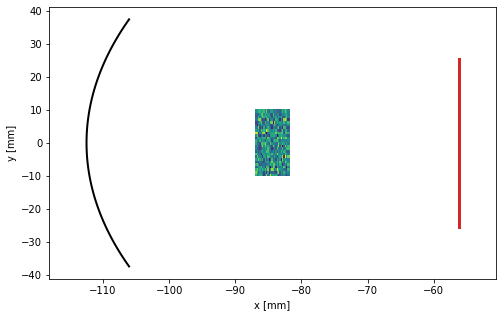

In [14]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist2d(results[:,0], results[:,1], bins = 25)
ax.plot(2*f*np.cos(_θ), 2*f*np.sin(_θ), lw = 2, color = 'k')
ax.plot([lt.x0, lt.x0], [lt.y0-lt.r, lt.y0+lt.r], lw = 3, color = 'C3')
ax.set_xlim([-2.1*f, lt.x0 + 0.1*f])
ax.set_ylim([1.1*(2*f*np.sin(_θ)).min(), 1.1*(2*f*np.sin(_θ)).max()])

ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

## Convergence test

In [15]:
f = 56.25
lt = LightTube(-f,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -1.5*f
beam_y = 0
beam_dx = 5
beam_dy = 20

percentage = []

Nlist = list(np.logspace(3,6,4,dtype=int)) + [int(2e6)]
for N in Nlist:    
    results = np.zeros([N,4])

    for idn in tqdm(range(N)):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
            
    percentage.append(100*results[:,-1].sum()/len(results))

100%|█████████████████████████████████████████████████████████████████████| 2000000/2000000 [01:47<00:00, 18560.81it/s]


Text(0, 0.5, 'into lighttube [%]')

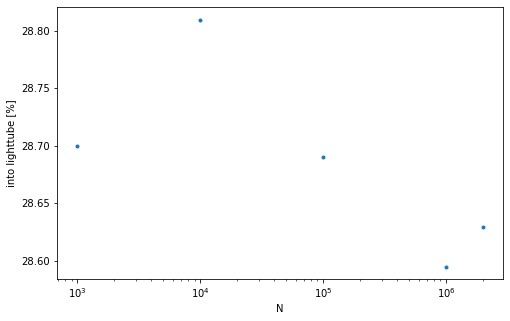

In [16]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Nlist, percentage, '.')
ax.set_xscale('log')
ax.set_xlabel('N')
ax.set_ylabel('into lighttube [%]')

### Check Spread

In [17]:
f = 56.25
lt = LightTube(-f,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -1.5*f
beam_y = 0
beam_dx = 5
beam_dy = 20

percentage = []

N = int(1e4)
for _ in tqdm(range(100)):    
    results = np.zeros([N,4])

    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
            
    percentage.append(100*results[:,-1].sum()/len(results))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


Text(0.5, 1.0, 'N = 10000')

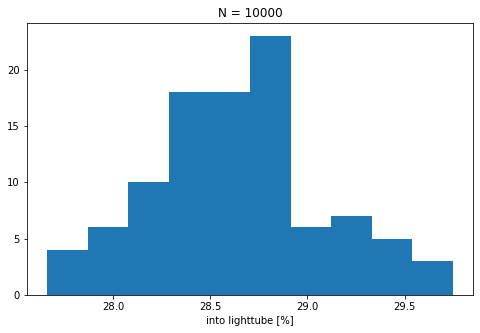

In [18]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(percentage)
ax.set_xlabel('into lighttube [%]')
ax.set_title(f'N = {N}')

In [19]:
f = 56.25
lt = LightTube(-f,0,25.4)
mirror = Circle(0,0,2*f)
beam_x = -1.5*f
beam_y = 0
beam_dx = 5
beam_dy = 20

percentage = []

N = int(1e5)
for _ in tqdm(range(100)):    
    results = np.zeros([N,4])

    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
            
    percentage.append(100*results[:,-1].sum()/len(results))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:26<00:00,  5.06s/it]


Text(0.5, 1.0, 'N = 100000')

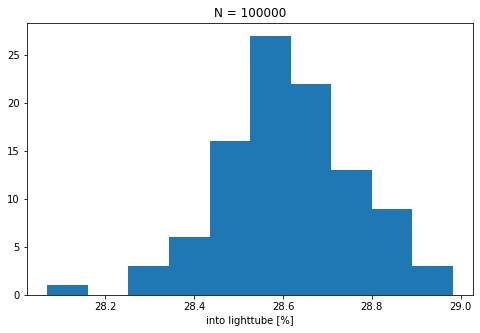

In [20]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(percentage)
ax.set_xlabel('into lighttube [%]') 
ax.set_title(f'N = {N}')

## Scan Position

In [28]:
from tqdm import tqdm

f = 56.25
lt = LightTube(-f,0,25.4)
mirror = Circle(0,0,2*f)
beam_y = 0
beam_dx = 5
beam_dy = 20




N = int(1e5)
results = np.zeros([N,4])

percentage = []
beam_xs = np.linspace(-1.8*f,-1.1*f, 10)
for beam_x in tqdm(beam_xs):
    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
    percentage.append(100*results[:,-1].sum()/len(results))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.91s/it]


Text(0, 0.5, 'into pmt [%]')

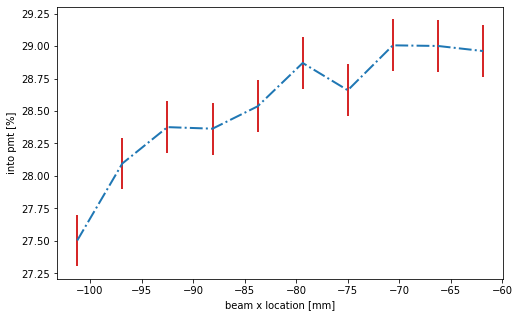

In [29]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(beam_xs, percentage, yerr = 0.2, fmt = '-.', lw = 2, ms = 12, ecolor = 'C3')
ax.set_xlabel('beam x location [mm]')
ax.set_ylabel('into pmt [%]')

## Scattered light minimization gives a fixed distance between the lighttube and beam 
Take here a distance of 1.5" between the beam and lighttube

In [30]:
from tqdm import tqdm

f = 56.25
lt = LightTube(-f,0,25.4)
mirror = Circle(0,0,2*f)
beam_y = 0
beam_dx = 5
beam_dy = 20

lighttube_beam_distance = 25.4*1.5

N = int(1e5)
results = np.zeros([N,4])

percentage = []
beam_xs = np.linspace(-1.5*f,-0.5*f, 10)
for beam_x in tqdm(beam_xs):
    lt = LightTube(beam_x+lighttube_beam_distance,0,25.4)
    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
    percentage.append(100*results[:,-1].sum()/len(results))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.77s/it]


Text(0, 0.5, 'into pmt [%]')

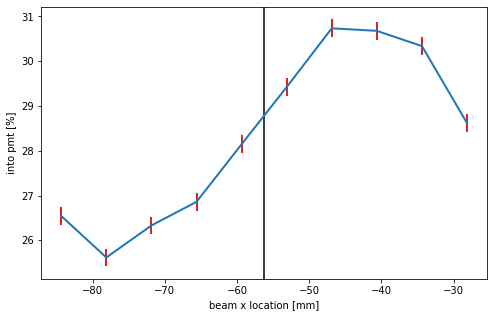

In [37]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(beam_xs, percentage, yerr = 0.2, fmt = '-', lw = 2, ms = 12, ecolor = 'C3')
ax.axvline(-f, color = 'k', zorder = 0)
ax.set_xlabel('beam x location [mm]')
ax.set_ylabel('into pmt [%]');

In [45]:
from tqdm import tqdm

f = 56.25
mirror = Circle(0,0,2*f)
beam_y = 0
beam_dx = 5
beam_dy = 20

lighttube_beam_distance = 25.4*2

N = int(1e5)
results = np.zeros([N,4])

percentage = []
beam_xs = np.linspace(-1.5*f,-0.5*f, 10)
for beam_x in tqdm(beam_xs):
    lt = LightTube(beam_x+lighttube_beam_distance,0,25.4)
    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
    percentage.append(100*results[:,-1].sum()/len(results))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.65s/it]


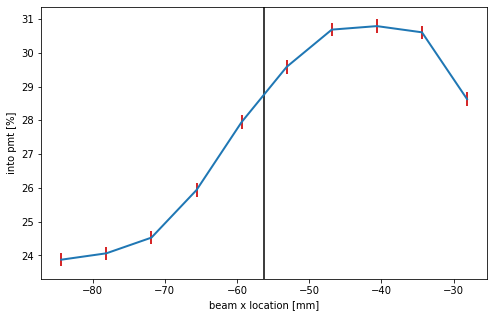

In [46]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(beam_xs, percentage, yerr = 0.2, fmt = '-', lw = 2, ms = 12, ecolor = 'C3')
ax.axvline(-f, color = 'k', zorder = 0)
ax.set_xlabel('beam x location [mm]')
ax.set_ylabel('into pmt [%]');

# No random spread
Only random direction

In [181]:
f = 56.25
mirror = Circle(0,0,2*f)
beam_y = 0
beam_dx = 0
beam_dy = 0

lighttube_beam_distance = 25.4*2

N = int(1e5)
results = np.zeros([N,4])

percentage = []
beam_xs = np.linspace(-1.8*f,-0.2*f, 15)
for beam_x in tqdm(beam_xs):
    lt = LightTube(beam_x+lighttube_beam_distance,0,25.4)
    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
    percentage.append(100*results[:,-1].sum()/len(results))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.74s/it]


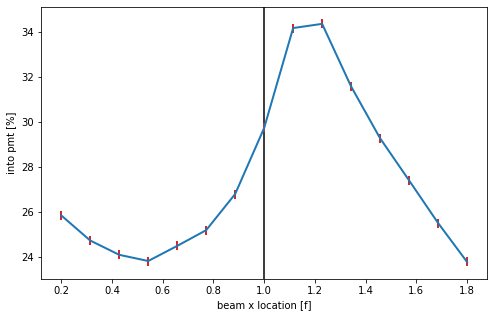

In [182]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar((beam_xs+2*f)/f, percentage, yerr = 0.2, fmt = '-', lw = 2, ms = 12, ecolor = 'C3')
ax.axvline(f/f, color = 'k', zorder = 0)
ax.set_xlabel('beam x location [f]')
ax.set_ylabel('into pmt [%]');

### Change Focus to $f=75$ mm

In [179]:
f = 75
mirror = Circle(0,0,2*f)
beam_y = 0
beam_dx = 0
beam_dy = 0

lighttube_beam_distance = 25.4*2

N = int(1e5)
results = np.zeros([N,4])

percentage = []
beam_xs = np.linspace(-1.8*f,-0.2*f, 15)
for beam_x in tqdm(beam_xs):
    lt = LightTube(beam_x+lighttube_beam_distance,0,25.4)
    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
    percentage.append(100*results[:,-1].sum()/len(results))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:10<00:00,  4.70s/it]


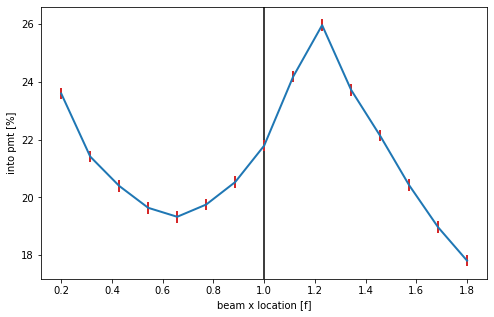

In [180]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar((beam_xs+2*f)/f, percentage, yerr = 0.2, fmt = '-', lw = 2, ms = 12, ecolor = 'C3')
ax.axvline(f/f, color = 'k', zorder = 0)
ax.set_xlabel('beam x location [f]')
ax.set_ylabel('into pmt [%]');

### Change Focus to $f=150$ mm

In [177]:
f = 150
mirror = Circle(0,0,2*f)
beam_y = 0
beam_dx = 0
beam_dy = 0

lighttube_beam_distance = 25.4*2

N = int(1e5)
results = np.zeros([N,4])

percentage = []
beam_xs = np.linspace(-1.8*f,-0.2*f, 15)
for beam_x in tqdm(beam_xs):
    lt = LightTube(beam_x+lighttube_beam_distance,0,25.4)
    for idn in range(N):
        x0 = np.random.random()*beam_dx-beam_dx/2 + beam_x
        y0 = np.random.random()*beam_dy-beam_dy/2 + beam_y
        angle = np.random.random()*np.pi + np.pi/2
        results[idn,:-1] = [x0,y0,angle]

        X = Ray(x0,y0,angle)
        x,y = zip(*X.line(200))
        intersect = circle_intersect(x[0],y[0],x[1],y[1], 2*f)

        li, refl = check_intersect(intersect, mirror)
        if isinstance(refl, Line):
            results[idn,3] = check_hit_lighttube(refl, lt)
        else:
            results[idn,3] = 0
    percentage.append(100*results[:,-1].sum()/len(results))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:07<00:00,  4.53s/it]


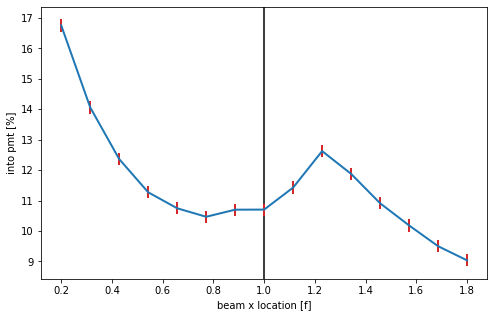

In [178]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar((beam_xs+2*f)/f, percentage, yerr = 0.2, fmt = '-', lw = 2, ms = 12, ecolor = 'C3')
ax.axvline(f/f, color = 'k', zorder = 0)
ax.set_xlabel('beam x location [f]')
ax.set_ylabel('into pmt [%]');

In [308]:
x = np.random.random([100,2])

In [318]:
xnorm = x/np.linalg.norm(x, axis = 1)[:,np.newaxis]

## Vectorized Version

In [24]:
def vectorized_intersect(i0, i1,r):
    di = i1 - i0
    dr = np.linalg.norm(di, axis = 1)
    D = i0[:,0]*i1[:,1] - i1[:,0]*i0[:,1]
    Δ = r**2*dr**2 - D**2
    
    dx = di[:,0]
    dy = di[:,1]
    
    x = np.array([(D*dy + np.sign(dy)*dx*np.sqrt(Δ))/dr**2, (D*dy - np.sign(dy)*dx*np.sqrt(Δ))/dr**2])
    y = np.array([(-D*dx + np.abs(dy)*np.sqrt(Δ))/dr**2, (-D*dx - np.abs(dy)*np.sqrt(Δ))/dr**2])
    return x,y

In [25]:
def vectorized_reflect(ray_start, ray_end,intersect,circle):
    cx = intersect[:,0] - circle.x
    cy = intersect[:,1] - circle.y
    
    t = np.empty(intersect.shape)
    t[:,0] = -cy
    t[:,1] = cx
    t /= circle.r
    tx = t[:,0]
    ty = t[:,1]
    
    incoming = ray_end - ray_start
    dx, dy = incoming[:,0], incoming[:,1]
    dot = (dx*tx+dy*ty)
    
    r = np.empty(t.shape)
    r[:,0] = tx*2*dot
    r[:,1] = ty*2*dot
    
    r -= incoming
    r /= np.linalg.norm(r, axis = 1)[:,np.newaxis]
    return r

In [26]:
def circle_reflect(line,circle,length):
    cx = line.x1 - circle.x
    cy = line.y1 - circle.y
    tx = -cy
    ty = cx
    tx /= circle.r
    ty /= circle.r
    
    dx,dy = line.norm()
    dot = 2*(dx*tx+dy*ty)
    tx *= dot
    ty *= dot
    rx = tx - dx
    ry = ty - dy
    dr = np.sqrt(rx**2+ry**2)
    rx /= dr
    ry /= dr
    return Line(line.x1, line.y1, line.x1+rx*length, line.y1+ry*length)

In [27]:
def vectorized_generate_rays(beam_x, beam_y, beam_dx, beam_dy, N, length):
    i0 = np.empty([N,2])
    i1 = np.empty([N,2])
    i0[:,0] = np.random.random(N)*beam_dx - beam_dx/2 + beam_x
    i0[:,1] = np.random.random(N)*beam_dy - beam_dy/2 + beam_y
    θ = np.random.random(N)*np.pi + np.pi/2
    i1[:,0] = np.cos(θ)*length + i0[:,0]
    i1[:,1] = np.sin(θ)*length + i0[:,1]
    
    
#     dx = i1[:,0]-i0[:,0]
#     dy = i1[:,1]-i0[:,1]
    
    return i0, i1

In [395]:
def vectorized_intersect_lighttube(intersect, reflect, lt_x, lt_y, lt_r):
    # generate ax+b coefficients from reflected ray
    a = reflect[:,1]/reflect[:,0]
    b = intersect[:,1] -  a * intersect[:,0]
    hit = np.abs(a*lt_x + b - lt_y) <= lt_r
    return hit

### testing, parallel line from $f$

In [396]:
f = 56.25
i0, i1 = vectorized_generate_rays(-f, 0, 0, 20, 10, 2*f)

In [397]:
x,y = vectorized_intersect(i0,i1,2*f)

In [398]:
ind = np.argmin(x, axis = 0)
x = x[(ind, np.arange(len(ind)))]
y = y[(ind, np.arange(len(ind)))]

In [399]:
incoming = i1-i0

In [400]:
ctest = Circle(0,0,2*f)
i = np.empty([len(x),2])
i[:,0] = x
i[:,1] = y
refl = vectorized_reflect(i0, i1, i, ctest)

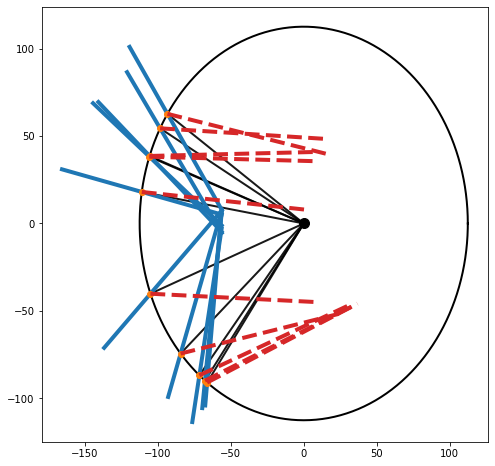

In [401]:
_θ = np.linspace(0, 2*np.pi, 501)

fig, ax = plt.subplots(figsize = (8,8))

ax.plot(2*f*np.cos(_θ), 2*f*np.sin(_θ), lw = 2, color = 'k')

indices = range(len(x))

for idx in indices:
    ax.plot([0,x[idx]], [0, y[idx]], color = 'k', alpha = 0.9, lw = 2)
    
for idx in indices:
    ax.plot([i0[idx,0], i1[idx,0]], [i0[idx,1], i1[idx,1]], lw = 4, color = 'C0')
    
ax.plot(x,y,'.', ms = 12, color = 'C1')

for idx in indices:
    ax.plot([x[idx],x[idx]+refl[idx,0]*2*f], [y[idx],y[idx]+refl[idx,1]*2*f], color = 'C3', ls = '--', lw = 4)
    
ax.plot(0,0, '.k', ms = 20)

In [402]:
# angle diff between ingoing and outgoing w.r.t. line through 
i_norm = i/np.linalg.norm(i, axis = 1)[:, np.newaxis]
incoming_norm = incoming/np.linalg.norm(incoming, axis = 1)[:, np.newaxis]
np.sum(i_norm*refl, axis = 1) + np.sum(incoming_norm*i_norm, axis = 1)

array([ 2.22044605e-16, -1.11022302e-16,  1.11022302e-16,  0.00000000e+00,
        1.11022302e-16, -2.22044605e-16,  1.11022302e-16,  0.00000000e+00,
        0.00000000e+00,  1.11022302e-16])

## Generate rays and run sim

In [432]:
f = 56.25
mirror = Circle(0,0,2*f)
beam_x = -f
beam_y = 0
beam_dx = 0
beam_dy = 0
N = int(1e6)

lt_x = 0
lt_y = 0
lt_r = 25.4

# generate rays from molecules
i0, i1 = vectorized_generate_rays(beam_x, beam_y, beam_dx, beam_dy, N, 2*f)

In [433]:
x,y = vectorized_intersect(i0,i1,2*f)
incoming = i1-i0
print(f'any nan : {np.any(np.isnan(x_intersect))}')
# only select intersects on left side (e.g. where concave mirror is)
ind = np.argmin(x, axis = 0)
x = x[(ind, np.arange(len(ind)))]
y = y[(ind, np.arange(len(ind)))]

any nan : False


In [434]:
ctest = Circle(0,0,2*f)
i = np.empty([len(x),2])
i[:,0] = x
i[:,1] = y
refl = vectorized_reflect(i0, i1, i, ctest)

In [441]:
into_lighttube = vectorized_intersect_lighttube(i, refl, lt_x, lt_y, lt_r)
# don't use rays that don't hit mirror, mirror has finite height and is not a complete circle
into_lighttube[np.abs(i[:,1]) > 75/2] = False
np.sum(into_lighttube)/len(into_lighttube)

0.297796

In [444]:
# angle diff between ingoing and outgoing w.r.t. line through center of circle
# should be zero
i_norm = i/np.linalg.norm(i, axis = 1)[:, np.newaxis]
incoming_norm = incoming/np.linalg.norm(incoming, axis = 1)[:, np.newaxis]
(np.sum(i_norm*refl, axis = 1) + np.sum(incoming_norm*i_norm, axis = 1))

array([-1.11022302e-16,  1.11022302e-16, -1.11022302e-16, ...,
        0.00000000e+00,  1.11022302e-16,  1.11022302e-16])

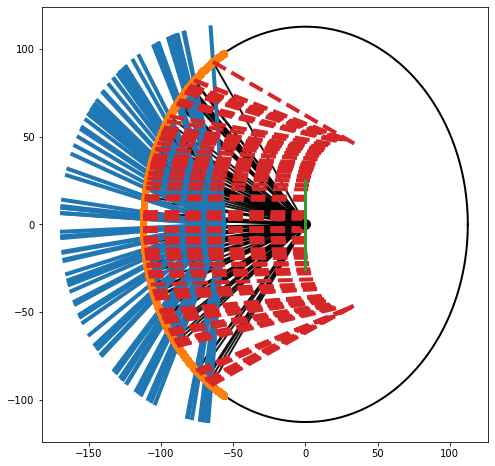

In [443]:
_θ = np.linspace(0, 2*np.pi, 501)

fig, ax = plt.subplots(figsize = (8,8))

ax.plot(2*f*np.cos(_θ), 2*f*np.sin(_θ), lw = 2, color = 'k')

indices = range(len(x))
indices = range(100)

for idx in indices:
    ax.plot([0,x[idx]], [0, y[idx]], color = 'k', alpha = 0.9, lw = 2)
    
for idx in indices:
    ax.plot([i0[idx,0], i1[idx,0]], [i0[idx,1], i1[idx,1]], lw = 4, color = 'C0')
    
ax.plot(x,y,'.', ms = 12, color = 'C1')

for idx in indices:
    ax.plot([x[idx],x[idx]+refl[idx,0]*2*f], [y[idx],y[idx]+refl[idx,1]*2*f], color = 'C3', ls = '--', lw = 4)
    
ax.plot(0,0, '.k', ms = 20)

ax.plot([lt_x, lt_x], [lt_y-lt_r, lt_y+lt_r], lw = 3, color = 'C2')

Vectorized result matches non-vectorized

## Now verify random spread

In [456]:
%%time

f = 56.25
mirror = Circle(0,0,2*f)
beam_x = -f
beam_y = 0
beam_dx = 5
beam_dy = 20

lt_x = 0
lt_y = 0
lt_r = 25.4

mirror_dh = 75

N = int(1e6)

# generate rays from molecules
i0, i1 = vectorized_generate_rays(beam_x, beam_y, beam_dx, beam_dy, N, 2*f)

# calculate intersection with mirror assuming a full circular mirror
# filter is placed later to determine which rays hit the mirrro
x,y = vectorized_intersect(i0,i1,2*f)

# only select intersects on left side (e.g. where concave mirror is)
ind = np.argmin(x, axis = 0)
x = x[(ind, np.arange(len(ind)))]
y = y[(ind, np.arange(len(ind)))]

# calculate reflections
i = np.empty([len(x),2])
i[:,0] = x
i[:,1] = y
refl = vectorized_reflect(i0, i1, i, ctest)

into_lighttube = vectorized_intersect_lighttube(i, refl, lt_x, lt_y, lt_r)
# don't use rays that don't hit mirror, mirror has finite height and is not a complete circle
into_lighttube[np.abs(i[:,1]) > mirror_dh/2] = False
np.sum(into_lighttube)/len(into_lighttube)

print(f'{100*np.sum(into_lighttube)/N:.2f}% of reflected left hits lighttube')

28.67% of reflected left hits lighttube
Wall time: 366 ms


matches other result, but is much faster (336 ms vs 56 s)
## Fix distance beam and lighttube, vary position mirror

distance between lighttube and beam is 2"

In [465]:
%%time

f = 56.25
mirror = Circle(0,0,2*f)
beam_x = -f
beam_y = 0
beam_dx = 5
beam_dy = 20

lt_x = 0
lt_y = 0
lt_r = 25.4

mirror_dh = 75

N = int(1e6)

lighttube_beam_distance = 25.4*2

percentage = []
beam_xs = np.linspace(-1.9*f,0, 101)
for beam_x in tqdm(beam_xs):
    # change lighttube distance to keep distance constant
    lt_x = beam_x + lighttube_beam_distance
    
    # generate rays from molecules
    i0, i1 = vectorized_generate_rays(beam_x, beam_y, beam_dx, beam_dy, N, 2*f)

    # calculate intersection with mirror assuming a full circular mirror
    # filter is placed later to determine which rays hit the mirrro
    x,y = vectorized_intersect(i0,i1,2*f)

    # only select intersects on left side (e.g. where concave mirror is)
    ind = np.argmin(x, axis = 0)
    x = x[(ind, np.arange(len(ind)))]
    y = y[(ind, np.arange(len(ind)))]

    # calculate reflections
    i = np.empty([len(x),2])
    i[:,0] = x
    i[:,1] = y
    refl = vectorized_reflect(i0, i1, i, ctest)

    into_lighttube = vectorized_intersect_lighttube(i, refl, lt_x, lt_y, lt_r)
    # don't use rays that don't hit mirror, mirror has finite height and is not a complete circle
    into_lighttube[np.abs(i[:,1]) > mirror_dh/2] = False
    np.sum(into_lighttube)/len(into_lighttube)
    
    percentage.append(100*np.sum(into_lighttube)/N)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:32<00:00,  3.10it/s]

Wall time: 32.6 s


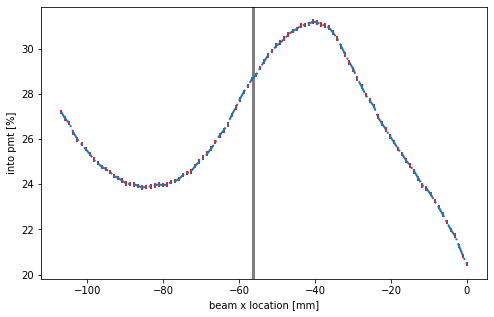

In [470]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(beam_xs, percentage, yerr = 0.1, fmt = '-.', lw = 2, ms = 12, ecolor = 'C3')
ax.set_xlabel('beam x location [mm]')
ax.set_ylabel('into pmt [%]')
ax.axvline(-f, lw = 3, color = 'k', zorder = 0, alpha = 0.5)

## Fix distance beam and lighttube, vary position mirror for various f
distance between lighttube and beam is 2"

In [484]:
%%time

results = {}

lt_y = 0
lt_r = 25.4

beam_y = 0

beam_dx = 5
beam_dy = 20

mirror_dh = 75

lighttube_beam_distance = 25.4*2

N = int(1e6)

for f in [56.25, 75, 150]:

    mirror = Circle(0,0,2*f)

    percentage = []
    beam_xs = np.linspace(-1.9*f,0, 101)
    for beam_x in tqdm(beam_xs):
        # change lighttube distance to keep distance constant
        lt_x = beam_x + lighttube_beam_distance

        # generate rays from molecules
        i0, i1 = vectorized_generate_rays(beam_x, beam_y, beam_dx, beam_dy, N, 2*f)

        # calculate intersection with mirror assuming a full circular mirror
        # filter is placed later to determine which rays hit the mirrro
        x,y = vectorized_intersect(i0,i1,2*f)

        # only select intersects on left side (e.g. where concave mirror is)
        ind = np.argmin(x, axis = 0)
        x = x[(ind, np.arange(len(ind)))]
        y = y[(ind, np.arange(len(ind)))]

        # calculate reflections
        i = np.empty([len(x),2])
        i[:,0] = x
        i[:,1] = y
        refl = vectorized_reflect(i0, i1, i, ctest)

        into_lighttube = vectorized_intersect_lighttube(i, refl, lt_x, lt_y, lt_r)
        # don't use rays that don't hit mirror, mirror has finite height and is not a complete circle
        into_lighttube[np.abs(i[:,1]) > mirror_dh/2] = False
        np.sum(into_lighttube)/len(into_lighttube)

        percentage.append(100*np.sum(into_lighttube)/N)
    
    results[f] = (beam_xs/f, percentage)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:33<00:00,  2.98it/s]

Wall time: 1min 38s


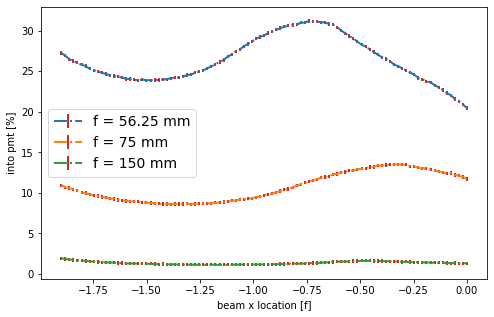

In [487]:
fig, ax = plt.subplots(figsize = (8,5))
for key, val in results.items():
    beam_xs, percentage = val
    ax.errorbar(beam_xs, percentage, yerr = 0.2, fmt = '-.', lw = 2, ms = 12, ecolor = 'C3', label = f'f = {key} mm')
    
ax.legend(fontsize = 14)
ax.set_xlabel('beam x location [f]')
ax.set_ylabel('into pmt [%]');

## Scan distance between lighttube and beam

In [489]:
%%time

results = {}

f = 56.25

lt_y = 0
lt_r = 25.4

beam_y = 0

beam_dx = 5
beam_dy = 20

mirror_dh = 75


N = int(1e6)

for lighttube_beam_distance in np.linspace(0.5, 5, 10)*25.4:
    
    mirror = Circle(0,0,2*f)

    percentage = []
    beam_xs = np.linspace(-1.9*f,0, 51)
    for beam_x in tqdm(beam_xs):
        # change lighttube distance to keep distance constant
        lt_x = beam_x + lighttube_beam_distance

        # generate rays from molecules
        i0, i1 = vectorized_generate_rays(beam_x, beam_y, beam_dx, beam_dy, N, 2*f)

        # calculate intersection with mirror assuming a full circular mirror
        # filter is placed later to determine which rays hit the mirrro
        x,y = vectorized_intersect(i0,i1,2*f)

        # only select intersects on left side (e.g. where concave mirror is)
        ind = np.argmin(x, axis = 0)
        x = x[(ind, np.arange(len(ind)))]
        y = y[(ind, np.arange(len(ind)))]

        # calculate reflections
        i = np.empty([len(x),2])
        i[:,0] = x
        i[:,1] = y
        refl = vectorized_reflect(i0, i1, i, ctest)

        into_lighttube = vectorized_intersect_lighttube(i, refl, lt_x, lt_y, lt_r)
        # don't use rays that don't hit mirror, mirror has finite height and is not a complete circle
        into_lighttube[np.abs(i[:,1]) > mirror_dh/2] = False
        np.sum(into_lighttube)/len(into_lighttube)

        percentage.append(100*np.sum(into_lighttube)/N)
    
    results[lighttube_beam_distance] = (beam_xs/f, percentage)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:16<00:00,  3.04it/s]

Wall time: 2min 49s


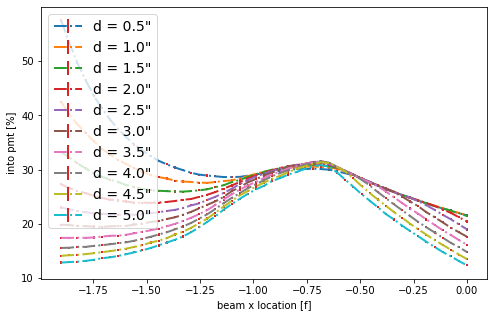

In [491]:
fig, ax = plt.subplots(figsize = (8,5))
for key, val in results.items():
    beam_xs, percentage = val
    ax.errorbar(beam_xs, percentage, yerr = 0.2, fmt = '-.', lw = 2, ms = 12, ecolor = 'C3', label = f'd = {key/25.4:.1f}"')
    
ax.legend(fontsize = 14)
ax.set_xlabel('beam x location [f]')
ax.set_ylabel('into pmt [%]');

## Show percentage captured by lighttube as a function of distance

assume point source, then capture angle is $2\tan(r_{lt}/d_{lt})$

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


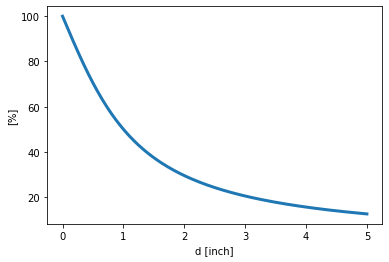

In [506]:
x = np.linspace(0,5,201)
plt.plot(x, 100*2*np.arctan(1/x)/np.pi, lw = 3)
plt.xlabel('d [inch]')
plt.ylabel('[%]');

In [513]:
2*np.arctan(1/2)/np.pi

0.2951672353008665